In [1]:
import os
os.chdir("/gpfs/home/asun/jin_lab/get/3_aggr_m23_finetune")
print(os.getcwd())

/gpfs/group/jin/asun/get/3_aggr_m23_finetune


In [4]:
import pandas as pd

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from gcell.utils.causal_lib import get_subnet, plot_comm, preprocess_net

from get_model.config.config import load_config
from get_model.run_region import run_zarr as run

/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
# get the celltype object based on the configuration
from gcell.cell.celltype import GETHydraCellType

from get_model.config.config import load_config
from get_model.config.config import export_config, load_config_from_yaml

cfg = load_config_from_yaml("interpret_gex_finetune_config.yaml")
#celltype = 'L6 IT' # the celltype you want to load, if you have ran the predict stage multiple times on different celltypes, you can specify the celltype you want to load here
#hydra_celltype = GETHydraCellType.from_config(cfg, celltype=celltype) # if you ran the predict stage multiple times on different celltypes, you can specify the celltype you want to load here
#cd14_mono = GETHydraCellType.from_config(cfg, celltype='cd14_mono')


In [26]:
gene_annot_dict.values()

overflow encountered in cast
overflow encountered in cast
overflow encountered in cast
overflow encountered in cast
overflow encountered in cast
overflow encountered in cast
overflow encountered in cast
overflow encountered in cast
overflow encountered in cast
overflow encountered in cast
overflow encountered in cast
overflow encountered in cast
overflow encountered in cast
overflow encountered in cast
overflow encountered in cast
overflow encountered in cast
overflow encountered in cast


dict_values([           gene_name Chromosome      Start        End  Strand      pred  \
0      0610009B22Rik      chr11   51688368   51689268       1  1.278472   
1      0610010F05Rik      chr11   23633176   23634038       1  2.137679   
2      0610010K14Rik      chr11   70237376   70238288       1  1.011866   
3      0610012G03Rik      chr16   31948000   31948904       1  1.546405   
4      0610025J13Rik       chr4   98320976   98321600       0  0.077847   
...              ...        ...        ...        ...     ...       ...   
19019           Caml      chr13   55622448   55623388       0  1.541335   
19020        Camsap1       chr2   25982932   25983856       1  2.035122   
19021        Camsap2       chr1  136345584  136346432       1  2.020089   
19022        Camsap3       chr8    3587293    3588166       0  0.001283   
19023         Camta1       chr4  151108128  151108992       1  2.440310   

            obs  accessibility  
0      1.158315            1.0  
1      1.992882     

In [13]:
observed_df = pd.DataFrame()
predicted_df = pd.DataFrame()
gene_annot_dict = {}

celltype_for_modeling = ['L6 IT',
                         'Astro',
                         'Endo',
                         'L5 ET',
                         'L5 IT',
                         'L6 CT',
                         'L6b',
                         'Lamp5',
                         'Meis2',
                         'Micro-PVM',
                         'OPC',
                         'Oligo',
                         'Peri',
                         'Pvalb',
                         'Sst',
                         'VLMC',
                         'Vip']

# Load all cell types
for celltype in celltype_for_modeling:
    try:
        cfg.dataset.leave_out_celltypes = celltype
        hydra_celltype = GETHydraCellType.from_config(cfg, celltype=celltype)
        gene_annot = hydra_celltype.gene_annot
        gene_annot_dict[celltype] = gene_annot
    except Exception as e:
        print(f"Error loading {celltype}: {e}")
        continue

# Intersect all gene indices to get common gene list
common_genes = set.intersection(*[set(g.index) for g in gene_annot_dict.values()])

# Extract observed/predicted into two matrices (genes x celltypes)
for celltype in celltype_for_modeling:
    df = gene_annot_dict[celltype].loc[list(common_genes)]
    observed_df[celltype] = df["obs"]
    predicted_df[celltype] = df["pred"]

Loading zarr data from /gpfs/home/asun/jin_lab/get/3_aggr_m23_finetune/output/finetune_aggr_multiome/interpret_training_from_finetune_m23_L6-IT_Astro_no_chr_split_binary_atac/L6 IT.zarr
Loading zarr data from /gpfs/home/asun/jin_lab/get/3_aggr_m23_finetune/output/finetune_aggr_multiome/interpret_training_from_finetune_m23_L6-IT_Astro_no_chr_split_binary_atac/Astro.zarr
Loading zarr data from /gpfs/home/asun/jin_lab/get/3_aggr_m23_finetune/output/finetune_aggr_multiome/interpret_training_from_finetune_m23_L6-IT_Astro_no_chr_split_binary_atac/Endo.zarr
Loading zarr data from /gpfs/home/asun/jin_lab/get/3_aggr_m23_finetune/output/finetune_aggr_multiome/interpret_training_from_finetune_m23_L6-IT_Astro_no_chr_split_binary_atac/L5 ET.zarr
Loading zarr data from /gpfs/home/asun/jin_lab/get/3_aggr_m23_finetune/output/finetune_aggr_multiome/interpret_training_from_finetune_m23_L6-IT_Astro_no_chr_split_binary_atac/L5 IT.zarr
Loading zarr data from /gpfs/home/asun/jin_lab/get/3_aggr_m23_finetune/

In [ ]:
merged_L6_IT_Astro = pd.merge(gene_annot_dict['L6 IT'], gene_annot_dict['Astro'], on=['gene_name', 'Start'], suffixes=('_L6_IT', '_Astro'))


In [45]:
from functools import reduce

# Step 1: create a list of dfs to merge
dfs_to_merge = []

for ct in celltype_for_modeling:
    df = gene_annot_dict[ct][["gene_name", "Start", "obs", "pred"]].copy()
    df = df.rename(columns={
        "obs": f"obs_{ct.replace(' ', '_')}",
        "pred": f"pred_{ct.replace(' ', '_')}"
    })
    dfs_to_merge.append(df)

# Step 2: perform a series of merges on ["gene_name", "Start"]
merged_all = reduce(
    lambda left, right: pd.merge(left, right, on=["gene_name", "Start"], how="inner"),
    dfs_to_merge
)

In [46]:
merged_all

,gene_name,Start,obs_L6_IT,pred_L6_IT,obs_Astro,pred_Astro,obs_Endo,pred_Endo,obs_L5_ET,pred_L5_ET,...,obs_Peri,pred_Peri,obs_Pvalb,pred_Pvalb,obs_Sst,pred_Sst,obs_VLMC,pred_VLMC,obs_Vip,pred_Vip
0,0610009B22Rik,51688368,1.158315,1.278472,1.177037,1.267617,1.168172,1.277162,1.118974,1.267617,...,1.251847,1.146489,1.155284,1.267617,1.184636,1.267617,1.282971,1.318714,1.156555,1.268903
1,0610010F05Rik,23633176,1.992882,2.137679,1.633165,2.132011,1.847202,2.141008,1.984820,2.132010,...,1.781761,2.098824,1.998081,2.132010,1.998537,2.132010,1.883750,2.147077,1.897221,2.131016
2,0610010K14Rik,70237376,1.161152,1.011866,1.028389,0.997905,1.454203,1.004944,1.032079,0.997905,...,1.227035,1.003546,0.972495,0.997905,1.034089,0.997905,1.275937,1.039172,1.093000,0.996110
3,0610012G03Rik,31948000,1.599664,1.546405,1.470027,1.538525,1.619777,1.545695,1.529906,1.538525,...,1.619708,1.557110,1.604830,1.538525,1.573114,1.538525,1.494242,1.588002,1.586365,1.538642
4,0610025J13Rik,98320976,0.139066,0.077847,0.052368,0.076655,0.000000,0.070445,0.088891,0.076655,...,0.474706,0.068586,0.017006,0.076655,0.029844,0.076655,0.116683,0.070293,0.065462,0.076445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14861,Vps37b,124031808,1.523275,1.541793,1.355217,1.541099,1.557561,1.535374,1.373946,1.541099,...,1.487851,1.502216,1.171942,1.541099,1.190652,1.541099,1.485577,1.542067,1.291060,1.540895
14862,Vps37c,10688374,1.188544,1.232165,1.326008,1.222893,1.234567,1.234189,1.173528,1.222892,...,1.075857,1.235063,1.072703,1.222892,1.085224,1.222892,1.261518,1.236232,1.120620,1.217132
14863,Vps37d,135077808,1.140894,0.841162,0.922661,0.826305,0.909832,0.866828,1.034363,0.826305,...,0.841990,0.962309,1.068280,0.826305,1.176482,0.826305,0.836091,0.905322,1.044794,0.826500
14864,Vps39,120352560,1.407090,1.472330,1.395088,1.458900,1.325495,1.462598,1.454582,1.458901,...,1.527958,1.481978,1.565631,1.458901,1.527912,1.458901,1.494242,1.547416,1.351689,1.457800


In [47]:
# Drop identifier columns
data_only = merged_all.drop(columns=["gene_name", "Start"])

# Split into obs and pred DataFrames
obs_df = data_only[[col for col in data_only.columns if col.startswith("obs_")]]
pred_df = data_only[[col for col in data_only.columns if col.startswith("pred_")]]

In [48]:
obs_df

,obs_L6_IT,obs_Astro,obs_Endo,obs_L5_ET,obs_L5_IT,obs_L6_CT,obs_L6b,obs_Lamp5,obs_Meis2,obs_Micro-PVM,obs_OPC,obs_Oligo,obs_Peri,obs_Pvalb,obs_Sst,obs_VLMC,obs_Vip
0,1.158315,1.177037,1.168172,1.118974,0.957282,1.165114,1.212910,1.230994,1.225103,1.252435,1.147061,1.248948,1.251847,1.155284,1.184636,1.282971,1.156555
1,1.992882,1.633165,1.847202,1.984820,1.956792,2.005913,2.011399,1.860709,1.883382,1.667464,1.846812,1.800275,1.781761,1.998081,1.998537,1.883750,1.897221
2,1.161152,1.028389,1.454203,1.032079,0.891297,1.203432,1.169179,1.140416,1.123286,1.308638,1.112078,1.231226,1.227035,0.972495,1.034089,1.275937,1.093000
3,1.599664,1.470027,1.619777,1.529906,1.370497,1.598253,1.619759,1.598665,1.684630,1.578110,1.384480,1.561038,1.619708,1.604830,1.573114,1.494242,1.586365
4,0.139066,0.052368,0.000000,0.088891,0.037377,0.041858,0.000000,0.000000,0.000000,0.081307,0.000000,0.000000,0.474706,0.017006,0.029844,0.116683,0.065462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14861,1.523275,1.355217,1.557561,1.373946,1.492792,1.542768,1.469302,1.276925,1.571279,1.741533,1.568788,1.299695,1.487851,1.171942,1.190652,1.485577,1.291060
14862,1.188544,1.326008,1.234567,1.173528,1.135035,1.203432,1.221151,1.071866,1.294829,1.308638,1.057822,1.283964,1.075857,1.072703,1.085224,1.261518,1.120620
14863,1.140894,0.922661,0.909832,1.034363,1.084157,1.083855,1.016363,1.058560,1.142000,0.773882,1.057822,0.770429,0.841990,1.068280,1.176482,0.836091,1.044794
14864,1.407090,1.395088,1.325495,1.454582,1.401775,1.426508,1.435766,1.417628,1.397601,1.663601,1.396000,1.397501,1.527958,1.565631,1.527912,1.494242,1.351689


In [49]:
# Correlation matrices
obs_corr = obs_df.corr(method='pearson')
pred_corr = pred_df.corr(method='pearson')

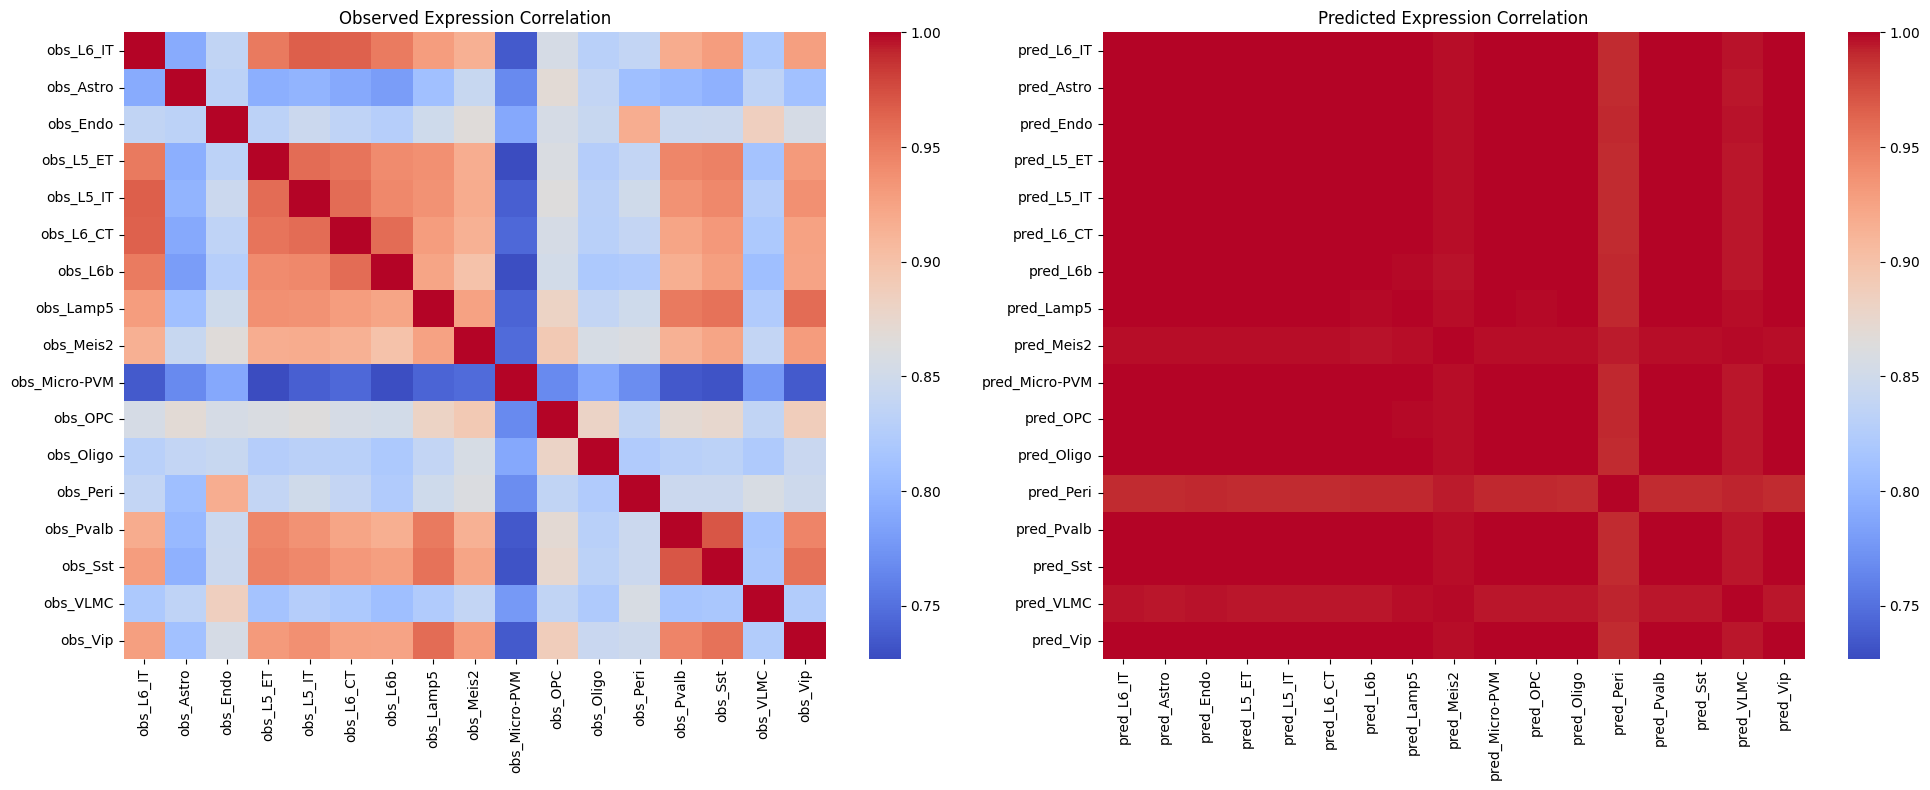

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate shared scale limits
vmin = min(obs_corr.min().min(), pred_corr.min().min())
vmax = max(obs_corr.max().max(), pred_corr.max().max())

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(obs_corr, cmap="coolwarm", annot=False, ax=axs[0], vmin=vmin, vmax=vmax)
axs[0].set_title("Observed Expression Correlation")

sns.heatmap(pred_corr, cmap="coolwarm", annot=False, ax=axs[1], vmin=vmin, vmax=vmax)
axs[1].set_title("Predicted Expression Correlation")

plt.tight_layout()
plt.show()

In [53]:
obs_df.columns

Index(['obs_L6_IT', 'obs_Astro', 'obs_Endo', 'obs_L5_ET', 'obs_L5_IT',
       'obs_L6_CT', 'obs_L6b', 'obs_Lamp5', 'obs_Meis2', 'obs_Micro-PVM',
       'obs_OPC', 'obs_Oligo', 'obs_Peri', 'obs_Pvalb', 'obs_Sst', 'obs_VLMC',
       'obs_Vip'],
      dtype='object')

In [54]:
import pandas as pd

# Extract the base cell type names from both DataFrames
obs_celltypes = [col.replace("obs_", "") for col in obs_df.columns]
pred_celltypes = [col.replace("pred_", "") for col in pred_df.columns]

# Get the intersection of cell types present in both
common_celltypes = list(set(obs_celltypes).intersection(pred_celltypes))

# Compute Pearson r for each common cell type
correlations = {
    celltype: pred_df[f"pred_{celltype}"].corr(obs_df[f"obs_{celltype}"])
    for celltype in common_celltypes
}

# Convert to DataFrame for inspection or plotting
pearson_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Pearson_r'])
pearson_df.index.name = 'CellType'
pearson_df = pearson_df.sort_values(by='Pearson_r', ascending=False)

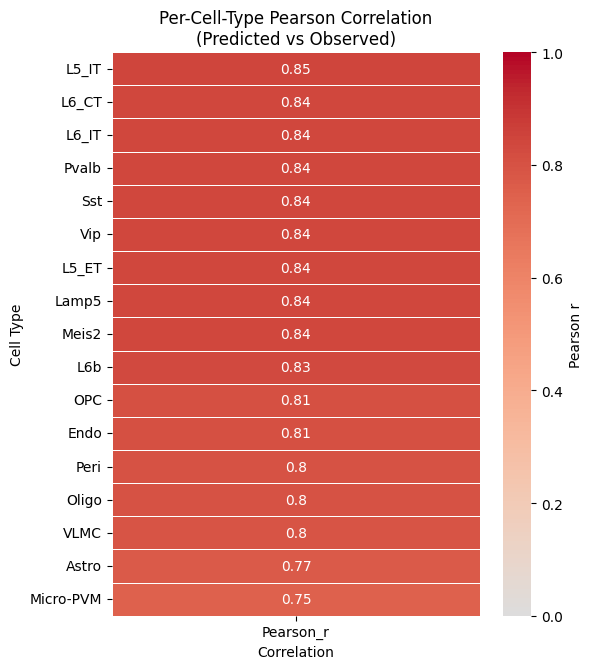

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, len(pearson_df) * 0.4))
sns.heatmap(
    pearson_df,
    annot=True,
    cmap='coolwarm',
    center=0,
    vmin=0,
    vmax=1,
    linewidths=0.5,
    cbar_kws={'label': 'Pearson r'}
)

plt.title("Per-Cell-Type Pearson Correlation\n(Predicted vs Observed)")
plt.xlabel("Correlation")
plt.ylabel("Cell Type")
plt.tight_layout()
plt.show()

In [33]:
df

overflow encountered in cast


,gene_name,Chromosome,Start,End,Strand,pred,obs,accessibility
0,0610009B22Rik,chr11,51688368,51689268,1,1.268903,1.156555,1.0
1,0610010F05Rik,chr11,23633176,23634038,1,2.131016,1.897221,1.0
2,0610010K14Rik,chr11,70237376,70238288,1,0.996110,1.093000,1.0
3,0610012G03Rik,chr16,31948000,31948904,1,1.538642,1.586365,1.0
4,0610025J13Rik,chr4,98320976,98321600,0,0.076445,0.065462,1.0
...,...,...,...,...,...,...,...,...
15828,Vps53,chr11,76179208,76180080,1,1.703138,1.731369,1.0
15829,Vps54,chr11,21238638,21239540,0,1.917035,1.980095,1.0
15830,Vps72,chr3,95110648,95111552,0,1.213030,1.257245,1.0
15831,Vps8,chr16,21422786,21423648,0,1.896468,1.894527,1.0


In [29]:
common_gene_list = set(gene_annot_dict['L6 IT'].index)
for celltype in celltype_for_modeling:
    try:
        common_gene_list = common_gene_list.intersection(set(gene_annot_dict[celltype].index))
    except Exception as e:
        print(f"Error loading {celltype}: {e}")
        continue
# then collect the expression
for celltype in celltype_for_modeling:
    try:
        gene_annot_dict[celltype] = gene_annot_dict[celltype].loc[np.array(common_gene_list)]
    except Exception as e:
        print(f"Error loading {celltype}: {e}")
        continue

In [41]:
gene_annot_dict["L6 IT"]["gene_name"].nunique()

14389

In [36]:
dupes = df[df.duplicated("gene_name",keep=False)]

         gene_name Chromosome      Start        End  Strand      pred  \
32   1500004A13Rik       chr3   88831336   88832104       1  2.032548   
33   1500004A13Rik       chr3   88832256   88833000       1  2.124520   
36   1500011B03Rik       chr5  114813456  114814360       1  1.514459   
37   1500011B03Rik       chr5  114822976  114823856       1  1.388945   
112  1700036A12Rik       chr9   60742516   60742972       0  0.238370   

          obs  accessibility  
32   1.952615            1.0  
33   1.952615            1.0  
36   1.607803            1.0  
37   1.607803            1.0  
112  0.000000            1.0  


overflow encountered in cast


In [38]:
len(dupes)

2660

In [43]:
dupes['gene_name'].nunique()

1216

In [32]:
len(common_gene_list)

15833

In [8]:
celltype_for_modeling = ['L6 IT',
                         'L5 ET',
                         'L5 IT',
                         'L6 CT',
                         'L6b',
                         'Lamp5',
                         'Meis2',
                         'Micro-PVM',
                         'OPC',
                         'Oligo',
                         'Peri',
                         'Pvalb',
                         'Sst',
                         'VLMC',
                         'Vip']

In [9]:
# Extract observed/predicted into two matrices (genes x celltypes)
for celltype in celltype_for_modeling:
    df = gene_annot_dict[celltype].loc[list(common_genes)]
    observed_df[celltype] = df["obs"]
    predicted_df[celltype] = df["pred"]

In [15]:
# Correlation matrices
obs_corr = observed_df.corr(method='pearson')
pred_corr = predicted_df.corr(method='pearson')

In [14]:
len(common_genes)

15833

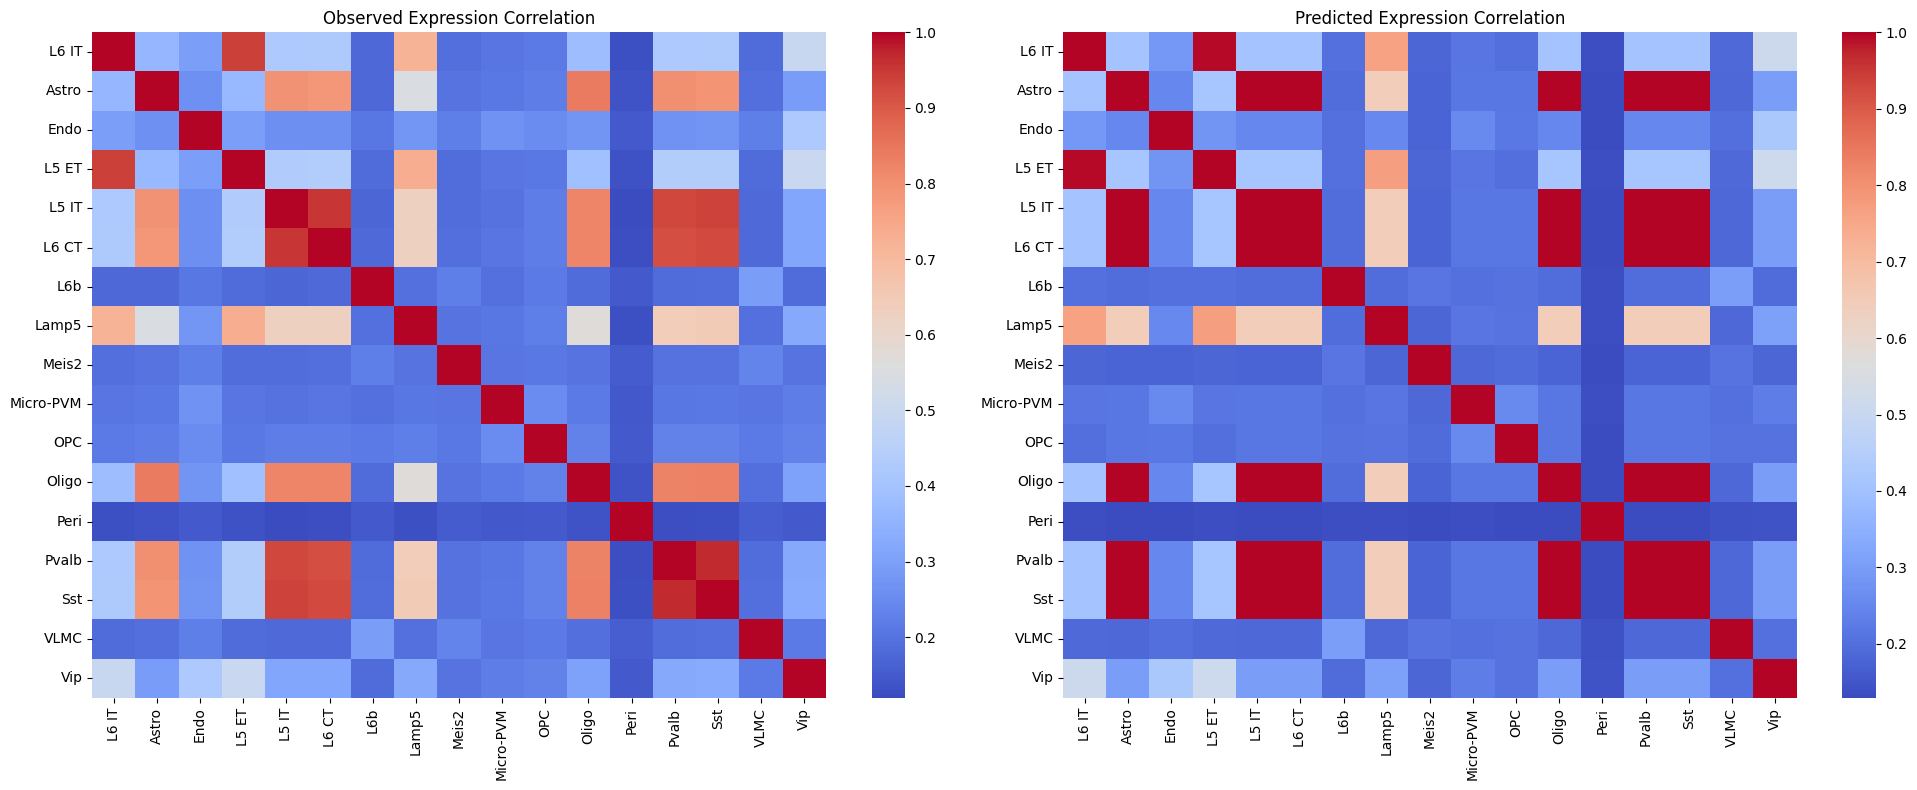

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(obs_corr, cmap="coolwarm", annot=False, ax=axs[0])
axs[0].set_title("Observed Expression Correlation")

sns.heatmap(pred_corr, cmap="coolwarm", annot=False, ax=axs[1])
axs[1].set_title("Predicted Expression Correlation")

plt.tight_layout()
plt.show()

In [17]:
observed_df

,L6 IT,Astro,Endo,L5 ET,L5 IT,L6 CT,L6b,Lamp5,Meis2,Micro-PVM,OPC,Oligo,Peri,Pvalb,Sst,VLMC,Vip
0,1.158315,1.177037,1.168172,1.118974,0.957282,1.165114,1.212910,1.230994,1.225103,1.252435,1.147061,1.248948,1.251847,1.155284,1.184636,1.282971,1.156555
1,1.992882,1.633165,1.847202,1.984820,1.956792,2.005913,2.011399,1.860709,1.883382,1.667464,1.846812,1.800275,1.781761,1.998081,1.998537,1.883750,1.897221
2,1.161152,1.028389,1.454203,1.032079,0.891297,1.203432,1.169179,1.140416,1.123286,1.308638,1.112078,1.231226,1.227035,0.972495,1.034089,1.275937,1.093000
3,1.599664,1.470027,1.619777,1.529906,1.370497,1.598253,1.619759,1.598665,1.684630,1.578110,1.384480,1.561038,1.619708,1.604830,1.573114,1.494242,1.586365
4,0.139066,0.052368,0.000000,0.088891,0.037377,0.041858,0.000000,0.000000,0.000000,0.081307,0.000000,0.000000,0.474706,0.017006,0.029844,0.116683,0.065462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15828,1.188544,1.355217,2.161570,1.173528,1.492792,1.542768,0.800551,1.071866,1.177171,0.000000,0.000000,1.299695,2.096771,1.171942,1.190652,1.444291,1.731369
15829,1.140894,1.326008,1.469832,1.034363,1.135035,1.203432,2.024435,1.058560,0.000000,1.872167,2.095410,1.283964,1.318765,1.072703,1.085224,1.453811,1.980095
15830,1.407090,0.922661,1.865070,1.454582,1.084157,1.083855,0.860696,1.417628,1.268266,0.000000,1.754443,0.770429,2.079187,1.068280,1.176482,2.046672,1.257245
15831,2.232107,1.395088,1.212002,2.172783,1.401775,1.426508,1.195942,2.167936,1.039141,1.931529,1.754443,1.397501,1.142760,1.565631,1.527912,1.238950,1.894527


In [37]:
predicted_df

,L6 IT,Astro,Endo,L5 ET,L5 IT,L6 CT,L6b,Lamp5,Meis2,Micro-PVM,OPC,Oligo,Peri,Pvalb,Sst,VLMC,Vip
0,1.278472,1.267617,1.277162,1.267617,1.267617,1.267617,1.285948,1.296636,1.283856,1.217471,1.269066,1.267617,1.146489,1.267617,1.267617,1.318714,1.268903
1,2.137679,2.132011,2.141008,2.132010,2.132010,2.132010,2.110828,2.143606,2.124573,2.128062,2.128723,2.132010,2.098824,2.132010,2.132010,2.147077,2.131016
2,1.011866,0.997905,1.004944,0.997905,0.997905,0.997905,0.985336,1.031243,1.029709,1.009418,1.007562,0.997905,1.003546,0.997905,0.997905,1.039172,0.996110
3,1.546405,1.538525,1.545695,1.538525,1.538525,1.538525,1.544683,1.558447,1.569063,1.541458,1.539943,1.538525,1.557110,1.538525,1.538525,1.588002,1.538642
4,0.077847,0.076655,0.070445,0.076655,0.076655,0.076655,0.081094,0.079321,0.068390,0.074761,0.070509,0.076655,0.068586,0.076655,0.076655,0.070293,0.076445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15828,1.232165,1.541099,1.920179,1.222892,1.541099,1.541099,0.779665,1.246965,1.216678,0.141612,0.455637,1.541099,2.066394,1.541099,1.541099,1.641602,1.703138
15829,0.841162,1.222893,1.239061,0.826305,1.222892,1.222892,2.238569,0.866208,0.053100,1.766770,1.933509,1.222892,1.539430,1.222892,1.222892,0.000212,1.917035
15830,1.472330,0.826305,1.899623,1.458901,0.826305,0.826305,0.662955,1.493160,1.194125,0.089427,0.473207,0.826305,2.235553,0.826305,0.826305,0.000144,1.213030
15831,2.105736,1.458900,1.095173,2.104111,1.458901,1.458901,1.073568,2.110487,1.011736,1.944880,0.309637,1.458901,0.882382,1.458901,1.458901,1.425238,1.896468


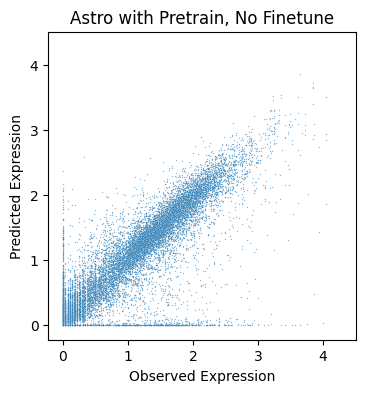

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['figure.dpi'] = 100

# get the data
x = observed_df['L6 IT']
y = predicted_df['L6 IT']

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x=x, y=y, s=1, alpha=0.5, ax=ax)
ax.set_title('Astro with Pretrain, No Finetune')

# compute max absolute value
max_val = max(np.abs(x).max(), np.abs(y).max())

# set axis limits symmetric around 0
ax.set_xlim(-max_val * 0.05, max_val)
ax.set_ylim(-max_val * 0.05, max_val)

ax.set_xlabel('Observed Expression')
ax.set_ylabel('Predicted Expression')
ax.set_aspect('equal')
plt.show()

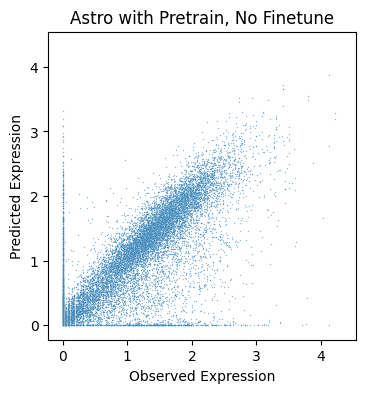

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['figure.dpi'] = 100

# get the data
x = observed_df['Astro']
y = predicted_df['Astro']

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x=x, y=y, s=1, alpha=0.5, ax=ax)
ax.set_title('Astro with Pretrain, No Finetune')

# compute max absolute value
max_val = max(np.abs(x).max(), np.abs(y).max())

# set axis limits symmetric around 0
ax.set_xlim(-max_val * 0.05, max_val)
ax.set_ylim(-max_val * 0.05, max_val)

ax.set_xlabel('Observed Expression')
ax.set_ylabel('Predicted Expression')
ax.set_aspect('equal')
plt.show()

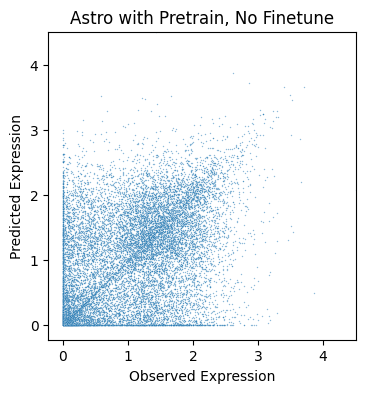

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['figure.dpi'] = 100

# get the data
x = predicted_df['L6 IT']
y = predicted_df['Astro']

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x=x, y=y, s=1, alpha=0.5, ax=ax)
ax.set_title('Astro with Pretrain, No Finetune')

# compute max absolute value
max_val = max(np.abs(x).max(), np.abs(y).max())

# set axis limits symmetric around 0
ax.set_xlim(-max_val * 0.05, max_val)
ax.set_ylim(-max_val * 0.05, max_val)

ax.set_xlabel('Observed Expression')
ax.set_ylabel('Predicted Expression')
ax.set_aspect('equal')
plt.show()